# Credit Approval Data Clustering with k-means, k-modes, and k-prototypes

*Objective:*
This notebook involves clustering the Credit Approval Dataset using k-means, k-modes, and k-prototypes algorithms, implemented from scratch. The goal is to group credit applicants into clusters based on numeric, categorical, and mixed attributes. Each algorithm will be applied to the dataset to understand how clustering performance is influenced by the different types of features.

I deliberately chose an algorithm where we have the target variable available. So we can compare the performance of the algorithms.

[Here](https://archive.ics.uci.edu/dataset/27/credit+approval) is a detailed look at the data

## Step 1: Data Loading and Preprocessing

Objective: Load the dataset, handle missing values, and encode categorical features manually for use in the k-means, k-modes, and k-prototypes algorithms.
As you can see no column names are provided. So we have no idea what these variables stand for. Here is the information that is provided:

    A1:	b, a.
    A2:	continuous.
    A3:	continuous.
    A4:	u, y, l, t.
    A5:	g, p, gg.
    A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
    A7:	v, h, bb, j, n, z, dd, ff, o.
    A8:	continuous.
    A9:	t, f.
    A10:	t, f.
    A11:	continuous.
    A12:	t, f.
    A13:	g, p, s.
    A14:	continuous.
    A15:	continuous.
    A16: +,-         (class attribute)
  

The task is:

1. Read in the dataset, label the columns appropriately, making sure we label the target column as "target" to avoid any confusion.
2. Deal with the missing values. For this dataset, the missing values are encoded as "?". We can tell `pd.read_csv()` how missing values are encoded using the `na_values=` argument. Then it will read the missing values correctly. To keep things simple, we will drop the rows with missing values since there are not that many of them in the first place.



In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write = True
np.set_printoptions(suppress=True,precision=4)

In [ ]:
# load the Credit Approval Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
credit = pd.read_csv(url, header=None, na_values='?')

In [ ]:
# add the column names
credit.columns = ["A" + str(x) for x in range(1, 17)]
credit.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [ ]:
# drop missing rows
credit = credit.dropna()

In [ ]:
# lets reset the index since we dropped some rows
credit.reset_index(inplace=True, drop=True)

## Step 2: Basic Data Exploration [5 points]

Let's do some basic EDA. Specifically, let's make some summary tables, some charts, and some insights that we gather from the exploration.

In [ ]:
# lets look at the continuous variablesm, describe them
continuous_variables = credit[['A2', 'A3', 'A8', 'A11', 'A14', 'A15']]
continuous_variables.describe()

,A2,A3,A8,A11,A14,A15
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,31.503813,4.829533,2.244296,2.502297,180.359877,1013.761103
std,11.838267,5.027077,3.371120,4.968497,168.296811,5253.278504
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.580000,1.040000,0.165000,0.000000,73.000000,0.000000
50%,28.420000,2.835000,1.000000,0.000000,160.000000,5.000000
75%,38.250000,7.500000,2.625000,3.000000,272.000000,400.000000
max,76.750000,28.000000,28.500000,67.000000,2000.000000,100000.000000


In [ ]:
# rename the 'A16' columne to target
credit.rename(columns = {'A16': 'target'}, inplace=True)

In [ ]:
# Map the target variable so that it is 0/1
mapping = {'+': 1, '-': 0}
credit['target'] = credit['target'].map(mapping)

In [ ]:
# Find the correlations between the numeric variables
correlation_matrix = continuous_variables.corr()

The scale of the variables seems to be very different. We will need to do some scaling.

In [ ]:
# standardize the numeric variables
for column in ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']:
  credit[column] = (credit[column] - credit[column].mean()) / credit[column].std()

Additional EDA:

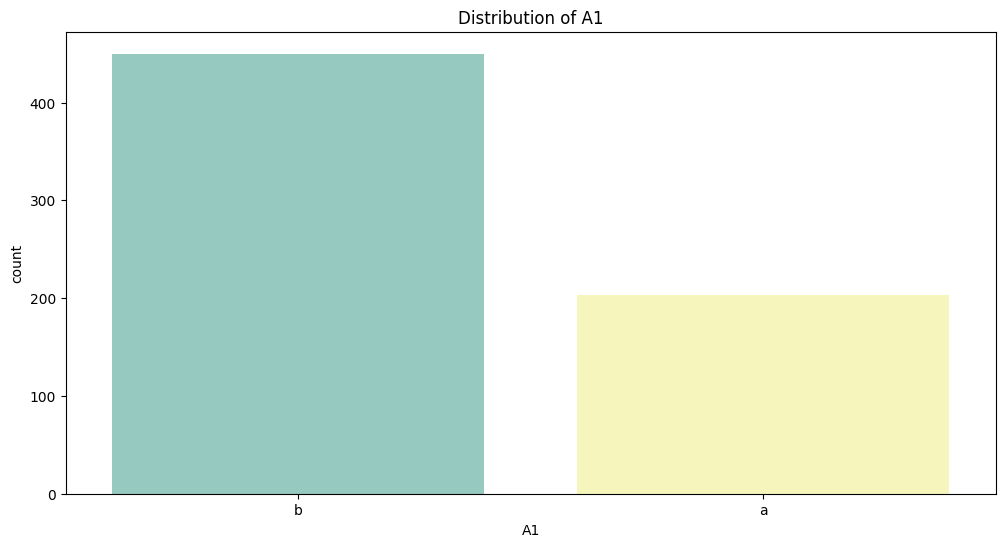

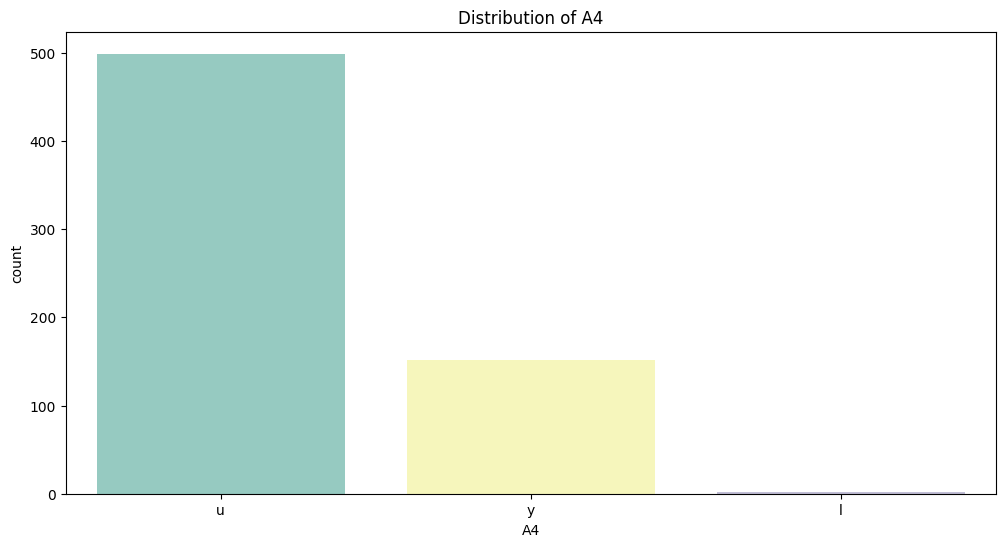

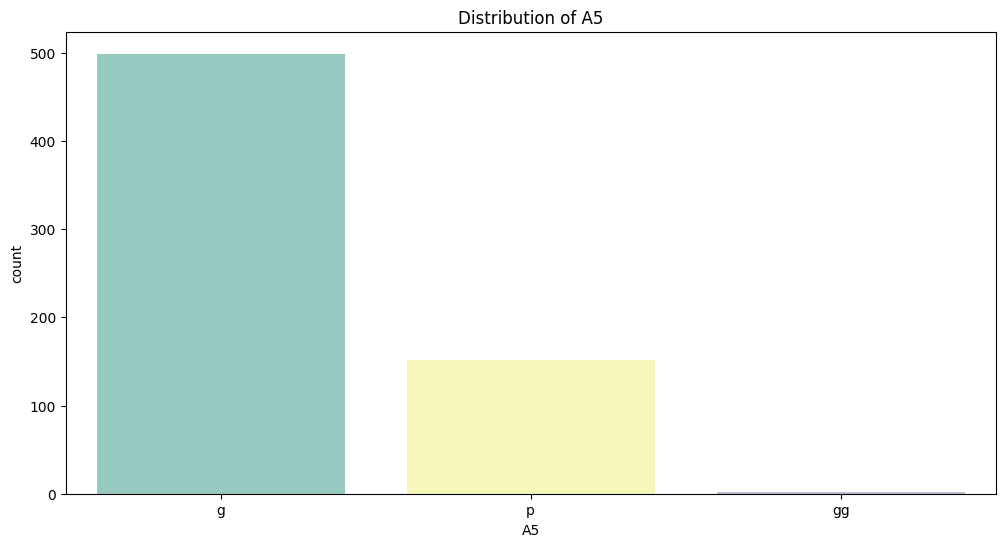

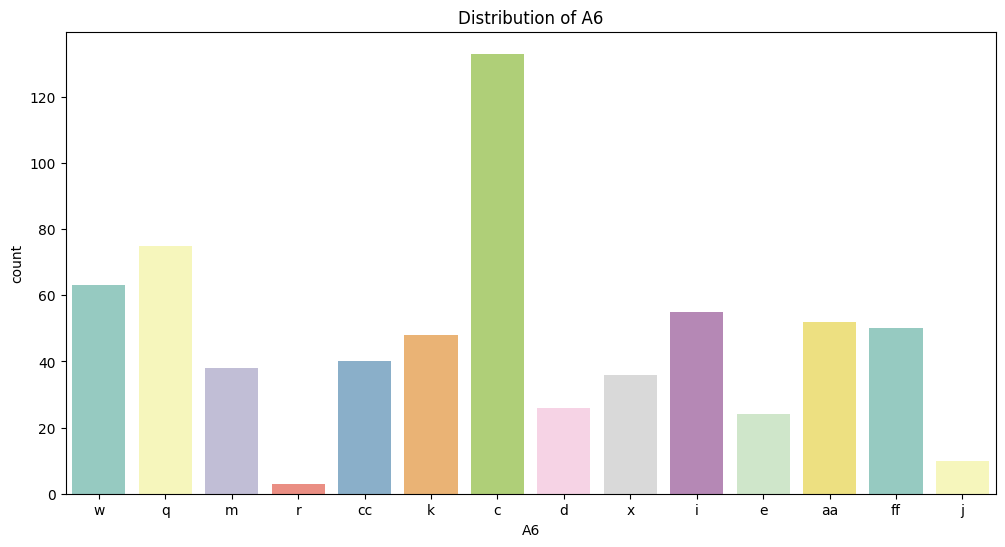

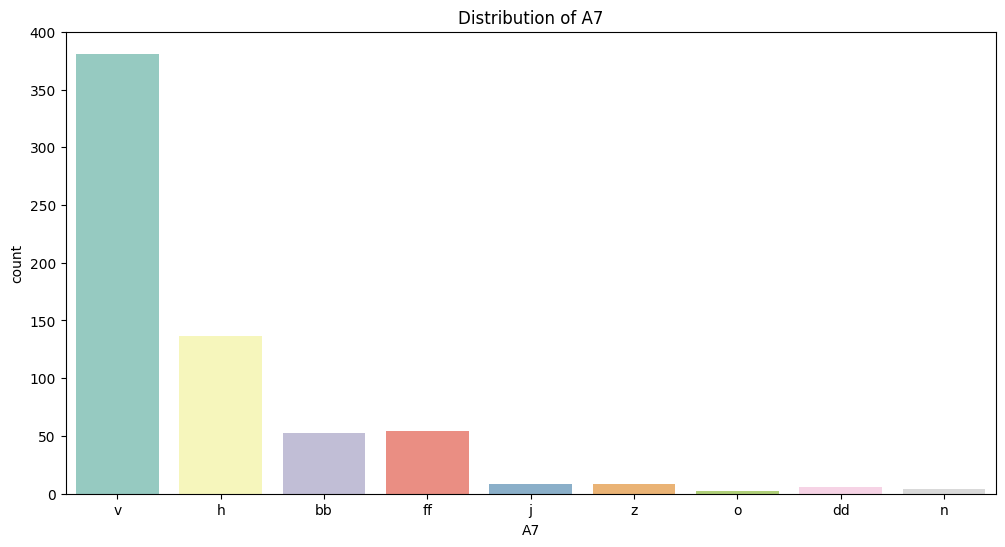

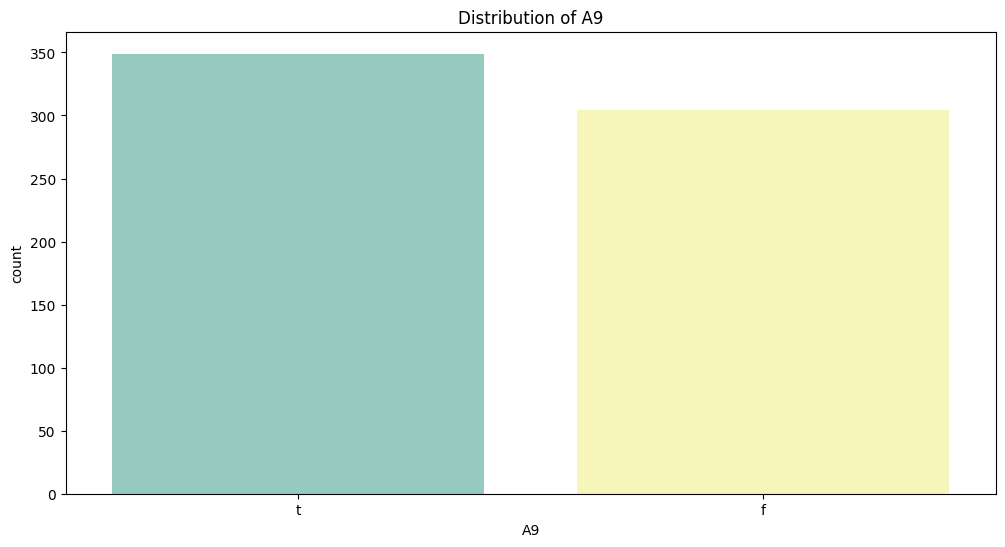

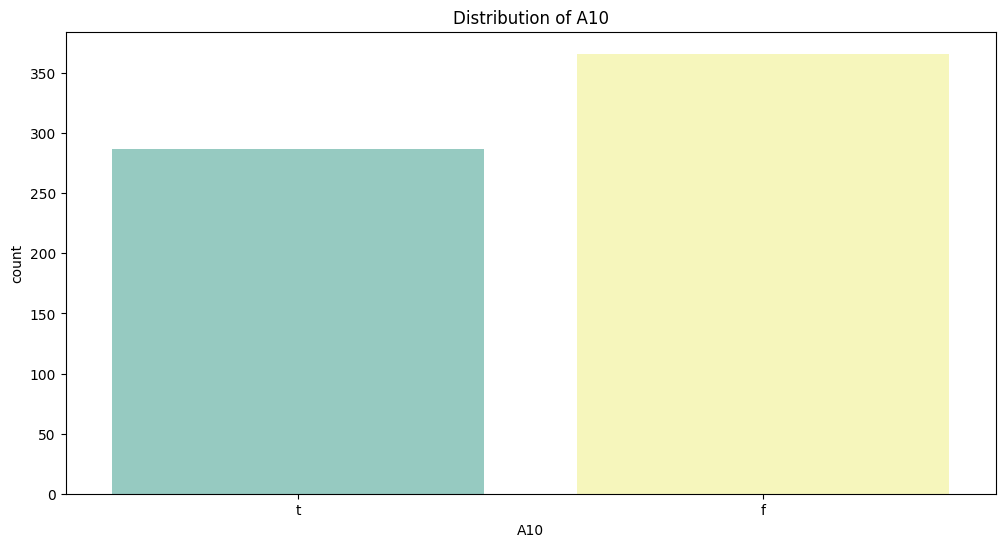

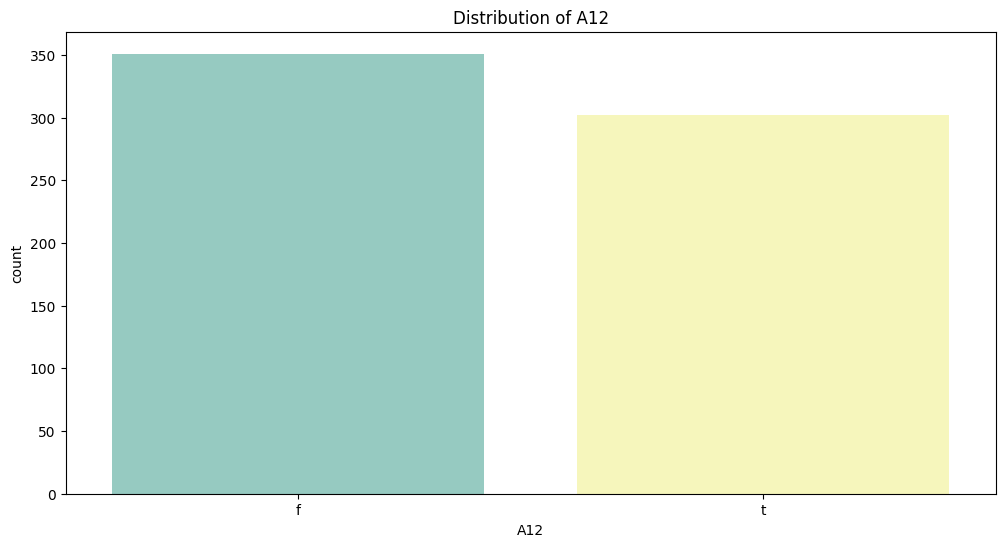

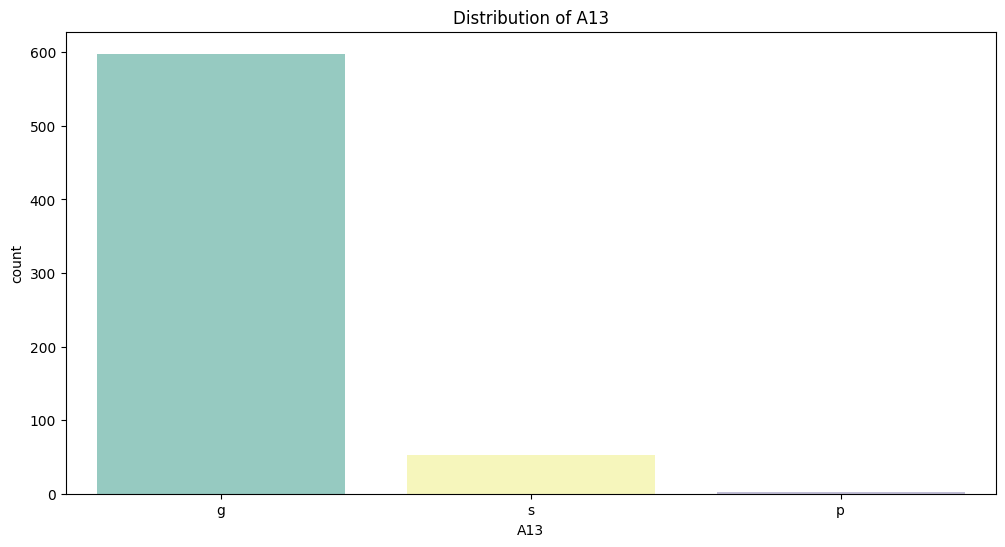

In [ ]:
# Taking a look at the modes of the categorical features
categorical_columns = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for col in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=credit, x=col, palette='Set3')
    plt.xticks(rotation=0)
    plt.title(f'Distribution of {col}')
    plt.show()

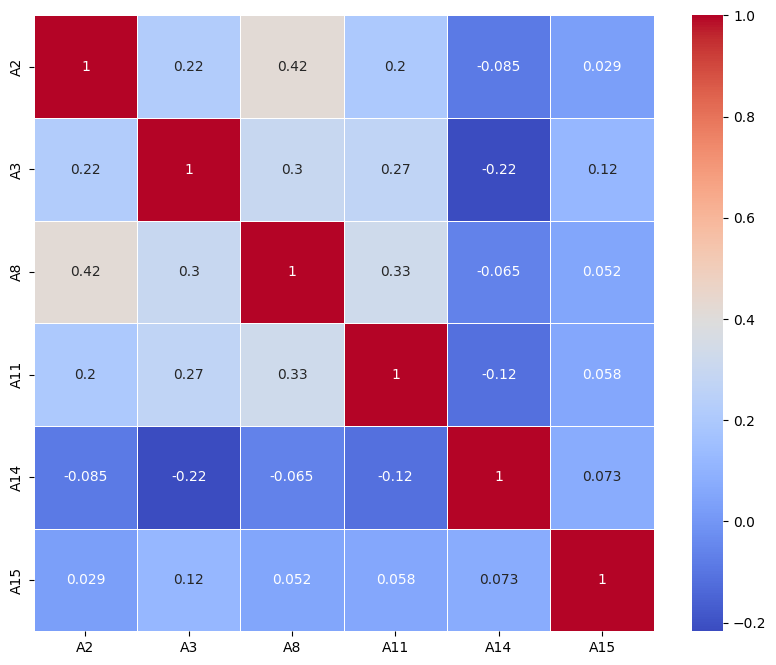

In [ ]:
# Taking a look at the correlation matrix heatmap of the numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

It seems like most of our numerical features are not very strongly correlated!

## Step 3: Implementing K-Means Algorithm

### Now lets implement the Euclidean distance

In [ ]:
def euclidean_distance(x: np.array, y: np.array) -> float:
    """Calculates the Euclidean distance between two points.

    Args:
        x (numpy.ndarray): The first point.
        y (numpy.ndarray): The second point.

    Returns:
        float: The Euclidean distance between the two points.
    """

    sum = 0
    for component in range(0, len(x)):
      sum += (y[component]-x[component])**2

    distance = np.sqrt(sum)
    return distance

### Initialize the centroids

Pick initial random points as your centroids.

In [ ]:
def initialize_centroids(
    X: pd.DataFrame, k: int, random_state: int = 12
) -> pd.DataFrame:
    """Randomly selects k initial centroids from the dataset.

    Args:
        X: The dataset from which to select centroids.
        k (int): The number of centroids to initialize.

    Returns:
        pd.DataFrame The initial centroids.
    """
    # set seed to reproduce results.
    np.random.seed(random_state)

    initial_centroids = X.sample(n=k, replace=False)
    return initial_centroids

### Assign clusters to each point (each person in the data)

Now that we have chosen initial points, lets write a function that takes in the dataset, and for each person (row) in the dataframe, it assigns a cluster.

In [ ]:
def assign_clusters(X: pd.DataFrame, centroids: pd.DataFrame) -> pd.DataFrame:
    """Calculates each data point's distance all centroids based on Euclidean distance.
    Assumes that the first row in centroids is the 0th cluster, the second row
    is the 1st cluster, and so on

    Args:
        X (pd.DataFrame): The dataset where each row is a data point.
        centroids (pd.DataFrame): The current centroids.

    Returns:
        pd.DataFrame: X with the appended columns of cluster to which it belongs
    """
    # lets first convert them into numpy arrays, this will make calculations faster
    X_numpy = X.values
    centroids_numpy = centroids.values

    new_column = []
    for row in X_numpy:
      min_distance = euclidean_distance(row, centroids_numpy[0])
      cluster = 0
      for i in range(1, len(centroids_numpy)):
        if min_distance > euclidean_distance(row, centroids_numpy[i]):
          min_distance = euclidean_distance(row, centroids_numpy[i])
          cluster = i
      new_column.append(cluster)

    X['cluster'] = np.array(new_column)
    return X

### Update the centroids based on the clusters formed

The new centroid is just the mean of all the points in that cluster. Note that this new centroid may not be a row in the dataframe, but some new values for all your features that don't exist in the credit dataframe

In [ ]:
def update_centroids(X: pd.DataFrame, k: int) -> pd.DataFrame:
    """Updates the centroids based on the mean of the points assigned to each cluster.

    Args:
        X (pd.DataFrame): The dataset where each row is a data point.
        k (int): The number of clusters.

    Returns:
        pd.DataFrame: The updated centroids with the right columnnames.
    """

    new_centroids = []
    for cluster in range(0, k):
      new_centroid = X[X['cluster'] == cluster].drop('cluster', axis=1).mean()
      new_centroids.append(new_centroid)

    column_names = list(X.drop('cluster', axis=1).columns)
    centroids = pd.DataFrame(np.array(new_centroids), columns=column_names)
    return centroids

### Run the K-Means algorithmn

In [ ]:
def k_means(X: pd.DataFrame, k: int, max_iters: int = 100) -> tuple:
    """Performs k-means clustering.

    Args:
        X (pd.DataFrame): The dataset where each row is a data point.
        k (int): The number of clusters.
        max_iters (int, optional): The maximum number of iterations. Defaults to 100.

    Returns:
        tuple: A tuple containing the final centroids and the cluster assignments.
    """
    # first initialize the centroids
    centroids = initialize_centroids(X, k)
    # then write a loop. within that loop:
    # 1. assign_clusters
    # 2. update centroids
    # 3. Keep repeating until the centroids dont change OR you hit max_iters.

    for i in range(0, max_iters):
      if X.get('cluster') is not None:
        X.drop('cluster', axis=1, inplace=True)
      X = assign_clusters(X, centroids)
      new_centroids = update_centroids(X, k)
      if centroids.equals(new_centroids):
        break
      centroids = new_centroids

    return centroids, X

Since k-means works only on the numeric data, lets create a new dataframe that contains only numeric

In [ ]:
# Lets run the k-means algorithm!
credit_numeric = credit[['A2', 'A3', 'A8', 'A11', 'A14', 'A15']]

In [ ]:
centroids_formed, clusters_formed = k_means(credit_numeric, k=2)

Now we will check how well the algorithm performed. We have our original target variable, the source of truth, that we coded as 0/1.

We now have clustered our dataset into two different clusters. We have called them clusters 0 and 1, but these are not the same as the 0/1 from the target variable.

So check how accurate we are, we need to check if we have mistakenly called taret 0 as cluster 1. So I create a cluster2 variable, and then calculate accuracy score with both cluster, and cluster2

In [ ]:
# lets add on to this the original target variable
clusters_formed['target'] = credit['target']
clusters_formed['cluster2'] = clusters_formed['cluster']
clusters_formed['cluster2'] = clusters_formed['cluster2'].map({0: 1, 1: 0})

In [ ]:
accuracy_score(clusters_formed.target, clusters_formed.cluster)

0.6339969372128637

In [ ]:
accuracy_score(clusters_formed.target, clusters_formed.cluster2)

0.3660030627871363

This does not look very accurate, and heavily imbalanced. Lets see if we can improve by adding categorical variables.

## Step 4: k-prototypes Clustering (Mixed Data)

 Implement k-prototypes from scratch, using numeric and categorical columns. Instead of clusters, we call them prototypes, and the centroid of a prototype has two components: the numeric component of means, and the categorical component of modes.

### Define a function to calculate simple matching dissimilarity

In [ ]:
def simple_matching_dissimilarity(x: np.array, y: np.array) -> float:
    """Calculates the simple matching dissimilarity between two categorical samples.

    Args:
        x (numpy.ndarray): the categorical features of the first sample.
        y (numpy.ndarray): the categorical features of the second sample.

    Returns:
        int: The number of mismatches between the two points.
    """

    missmatches = 0
    for i in range(0, len(x)):
      if x[i] != y[i]:
        missmatches += 1
    return missmatches

### Define a function to calculate mixed dissimilarity


In [ ]:
def mixed_dissimilarity(
    x_num: np.array, y_num: np.array, x_cat: list, y_cat: list, gamma: float
) -> float:
    """Calculates the mixed dissimilarity between two sample with numeric and categorical features.
    This would be given by  num_diff + gamma * cat_diff

    Args:
        x_num (numpy.ndarray): The numeric part of the first sample.
        y_num (numpy.ndarray): The numeric part of the second sample.
        x_cat (numpy.ndarray): The categorical part of the first sample.
        y_cat (numpy.ndarray): The categorical part of the second sample.
        gamma (float): The weighting factor for categorical features.

    Returns:
        float: The combined dissimilarity score.
    """
    return euclidean_distance(x_num, y_num) + gamma * simple_matching_dissimilarity(x_cat, y_cat)

### Initialize the prototypes

At first, let's just pick initial random points as our prototypes.


In [ ]:
def initialize_centroids_mixed(
    X: pd.DataFrame, k: int, random_state: int = 12
) -> pd.DataFrame:
    """Randomly selects k initial centroids from the dataset.

    Args:
        X: The dataset from which to select centroids.
        k (int): The number of centroids to initialize.

    Returns:
        pd.DataFrame The initial centroids.
    """
    # set seed to reproduce results.
    np.random.seed(random_state)

    initial_centroids_mixed = X.sample(n=k, replace=False)
    return initial_centroids_mixed

### Assign prototypes to each point (each person in the dataset)

This function assigns each sample to the nearest prototype based on mixed dissimilarity.



In [ ]:
def assign_prototypes_mixed(
    X: pd.DataFrame,
    cat_features: list,
    num_features: list,
    centroids: pd.DataFrame,
    gamma: float,
) -> pd.DataFrame:
  """Assigns each sample to the nearest prototype based on mixed dissimilarity.

  Args:
      X (pd.DataFrame): The dataset containing all your data
      cat_features (list): list of all categorical features
      num_features (list): list of all num_features features
      centroids (pd.DataFrame): A dataframe with k rows, corresponding to the
        centroid of each prototype
      gamma (float): The weighting factor for categorical features.

  Returns:
      pd.DataFrame: X with the appended columns of cluster to which it belongs
  """
  # Lets split the data into categorical and numerical numpy arrays
  X_num = X[num_features].values
  X_cat = X[cat_features].values

  new_column = []
  centroids_num = centroids[num_features].values
  centroids_cat = centroids[cat_features].values

  for i in range(0, len(X)): #for every row
    min_distance = mixed_dissimilarity(X_num[i], centroids_num[0], X_cat[i], centroids_cat[0], gamma)
    cluster = 0
    for j in range(0, len(centroids)): #calculate the distance from every centroids
      if min_distance > mixed_dissimilarity(X_num[i], centroids_num[j], X_cat[i], centroids_cat[j], gamma):
        min_distance = mixed_dissimilarity(X_num[i], centroids_num[j], X_cat[i], centroids_cat[j], gamma)
        cluster = j
    new_column.append(cluster)

  X['prototype'] = np.array(new_column)
  return X

### Update the centroids based on the prototypes formed

The new centroid is just the mean of all the numeric featurse in that prototypes, and the mode of all the categorical features in the prototypes.

Note that this new centroid may not be a row in the dataframe, but some new values for all your features that don't exist in the credit dataframe

In [ ]:
def update_centroids_mixed(
    X: pd.DataFrame, cat_features: list, num_features: list, k: int
) -> pd.DataFrame:
  """Updates the centroids for each prototype in k-prototypes.

  Args:
      X (pd.DataFrame): The dataset containing all your data
      cat_features (list): list of all categorical features
      num_features (list): list of all num_features features
      k (int): The number of prototypes.

  Returns:
      pd.DataFrame: The updated centroids with the right columnnames.
  """

  new_centroids_cat = []
  new_centroids_num = []
  for cluster in range(0, k):
    new_centroid_num = X[X['prototype'] == cluster].drop(cat_features + ['prototype'], axis=1).mean()
    new_centroids_num.append(new_centroid_num)

    new_centroid_cat = X[X['prototype'] == cluster].drop(num_features + ['prototype'], axis=1).mode().iloc[0]
    new_centroids_cat.append(new_centroid_cat)

  new_centroids_num_df = pd.DataFrame(np.array(new_centroids_num), columns=num_features)
  new_centroids_cat_df = pd.DataFrame(np.array(new_centroids_cat), columns=cat_features)

  return pd.concat([new_centroids_num_df, new_centroids_cat_df], axis=1)

### Implement the k-prototypes

In [ ]:
def k_prototypes(
    X: pd.DataFrame,
    cat_features: list,
    num_features: list,
    k: int,
    gamma: float,
    max_iters: int = 100,
) -> tuple:
    """Performs k-prototypes clustering.

    Args:
        X (numpy.ndarray): The numeric part of the dataset.
        k (int): The number of clusters.
        gamma (float): The weighting factor for categorical features.
        max_iters (int, optional): The maximum number of iterations. Defaults to 100.

    Returns:
        tuple: A tuple containing the final prototypes and the cluster assignments.
    """
    centroids = initialize_centroids_mixed(X, k)
    # get the columns in the right order
    centroids = centroids[num_features + cat_features]

    for i in range(0, max_iters):
      if X.get('prototype') is not None:
        X.drop('prototype', axis=1, inplace=True)
      X = assign_prototypes_mixed(X, cat_features, num_features, centroids, gamma)
      new_centroids = update_centroids_mixed(X, cat_features, num_features, k)
      if centroids.equals(new_centroids):
        break
      centroids = new_centroids

    return centroids, X

In [ ]:
num_features = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
cat_features = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

In [ ]:
X = credit.drop('target', axis=1)

In [ ]:
initial_centroids = initialize_centroids_mixed(X, 2)

In [ ]:
centroids, prototypes = k_prototypes(X, cat_features, num_features, 2, gamma=0.5)

In [ ]:
# lets add on to this the original target variable
prototypes['target'] = credit['target']
prototypes['prototype2'] = prototypes['prototype']
prototypes['prototype2'] = prototypes['prototype2'].map({0: 1, 1: 0})

In [ ]:
accuracy_score(prototypes.target, prototypes.prototype)

0.8101071975497703

In [ ]:
accuracy_score(prototypes.target, prototypes.prototype2)

0.18989280245022971

Wow, we went up a lot in accuracy! Not too bad with a simple unsupervised learning algorithm :)